In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io
from PIL import Image
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.cluster import KMeans

In [10]:
img_emb = pd.read_csv('/Users/aline/Desktop/fashion-dataset/img_emb.csv')
img_emb.drop(columns = 'Unnamed: 0', inplace=True)
sampled_df = pd.read_csv('/Users/aline/Desktop/fashion-dataset/sampled_df.csv')
sampled_df.drop(columns = 'Unnamed: 0', inplace=True)

In [12]:

num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(img_emb)  # Fit the model and predict cluster labels

# Add the cluster labels back to the original img_emb DataFrame (with img_id and img_path)
img_emb['cluster'] = clusters

In [14]:
img_emb['id'] = sampled_df['id']
img_emb['path'] = sampled_df['path']

t-SNE done! Time elapsed: 18.9325749874115 seconds


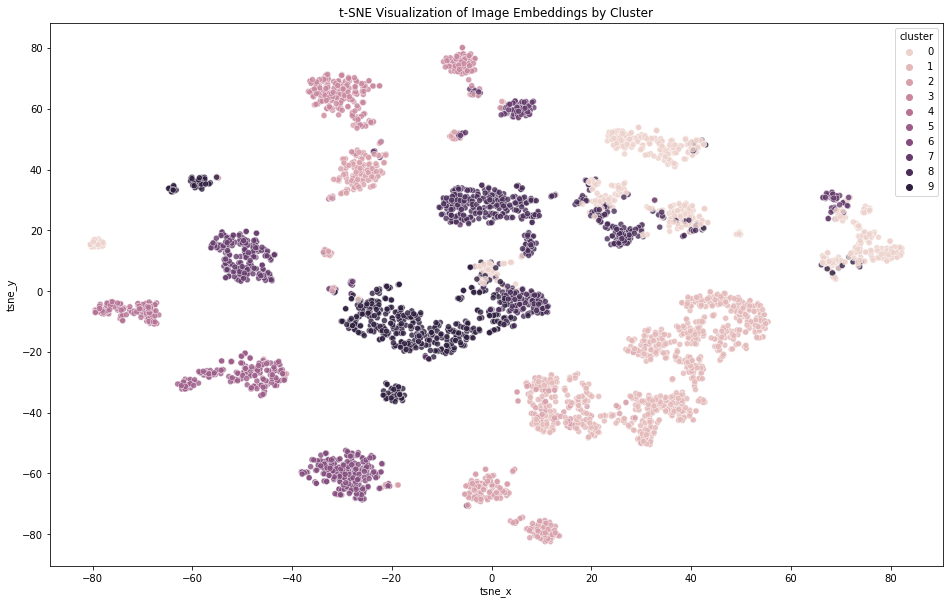

In [17]:
# Step 2: t-SNE to reduce the 2048-d embeddings to 2D for visualization
time_start = time.time()
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(img_emb.drop(columns=['id','path','cluster']))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Add the t-SNE results back to the DataFrame
img_emb['tsne_x'] = tsne_results[:, 0]
img_emb['tsne_y'] = tsne_results[:, 1]

# Plot the t-SNE results, coloring by cluster
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne_x", y="tsne_y",
                hue="cluster",
                data=img_emb,
                legend="full",
                alpha=0.8)
plt.title("t-SNE Visualization of Image Embeddings by Cluster")
plt.show()


In [48]:
# Function to recommend products from the same cluster based on cosine similarity
def recommend_products_cosine(img_id, img_emb, num_recommendations=5):
    # Get the feature vector of the input product
    product_vector = img_emb[img_emb['id'] == img_id].drop(columns = ['cluster','id','path','tsne_x','tsne_y'])
    
    # Get the cluster of the input product
    product_cluster = img_emb.loc[img_emb['id'] == img_id, 'cluster'].values[0]
    
    # Get all products in the same cluster
    same_cluster = img_emb[img_emb['cluster'] == product_cluster]
    
    # Exclude the input image itself from the recommendations
    same_cluster = same_cluster[same_cluster['id'] != img_id]
 
    # Compute cosine similarity between the input product and others in the same cluster
    similarities = cosine_similarity(product_vector, same_cluster.drop(columns = ['cluster','id','path','tsne_x','tsne_y']).values).flatten()
    
    # Add the similarity scores to the DataFrame
    same_cluster = same_cluster.assign(similarity=similarities)
    
    # Sort products by similarity in descending order
    same_cluster = same_cluster.sort_values(by='similarity', ascending=False)
    
    # Select the top N most similar products
    recommended_products = same_cluster.head(num_recommendations)
    
    img = Image.open('/Users/aline/Desktop/fashion-dataset/'+img_emb[img_emb['id'] == img_id]['path'].values[0])
    plt.imshow(img)
    plt.title(f"Product ID:{img_id}, Cluster: {product_cluster}")
    plt.show()
    
    print('--------------------------------------------------------------------')
    
    # Display the recommended products
    plt.figure(figsize=(15, 5))
    for idx, row in recommended_products.iterrows():
        img_path = row['path']
        img = Image.open('/Users/aline/Desktop/fashion-dataset/'+img_path)
        plt.imshow(img)
        plt.title(f"Recommended Product: {row['id']}")
        print(f"Recommended Product ID: {row['id']}, Similarity: {row['similarity']}, Cluster: {row['cluster']}")
        plt.axis('off')  # Hide the axis for a cleaner look
    
        plt.show()


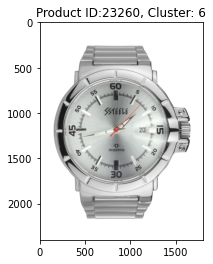

--------------------------------------------------------------------
Recommended Product ID: 23261, Similarity: 0.958242063942943, Cluster: 6


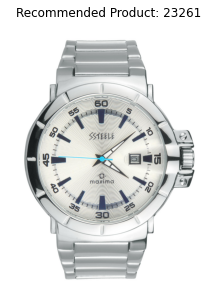

Recommended Product ID: 31825, Similarity: 0.9370554091760275, Cluster: 6


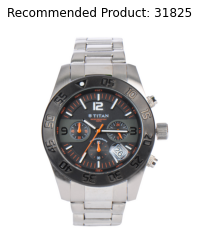

Recommended Product ID: 45203, Similarity: 0.9334983149174524, Cluster: 6


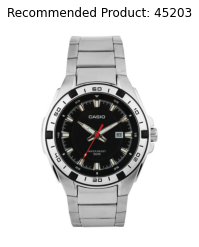

Recommended Product ID: 21478, Similarity: 0.9326689109497353, Cluster: 6


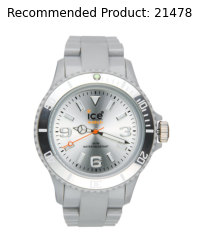

Recommended Product ID: 23292, Similarity: 0.9317347612996226, Cluster: 6


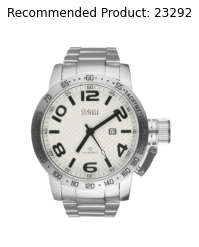

In [49]:
# Example usage
recommend_products_cosine(img_id=23260, img_emb=img_emb, num_recommendations=5)  # Replace with your actual img_id

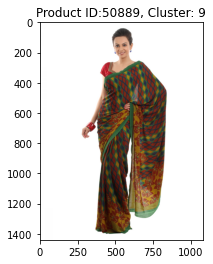

--------------------------------------------------------------------
Recommended Product ID: 52895, Similarity: 0.933966215023498, Cluster: 9


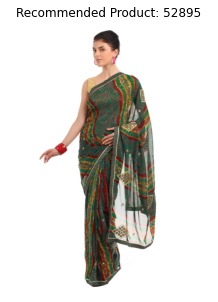

Recommended Product ID: 52999, Similarity: 0.8986241410881219, Cluster: 9


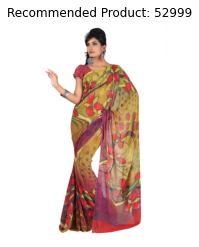

Recommended Product ID: 59616, Similarity: 0.896694355216952, Cluster: 9


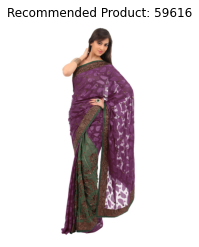

Recommended Product ID: 59599, Similarity: 0.8960171712144864, Cluster: 9


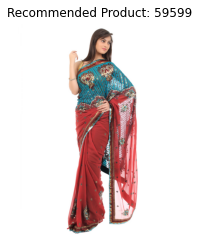

Recommended Product ID: 57975, Similarity: 0.8916042755107635, Cluster: 9


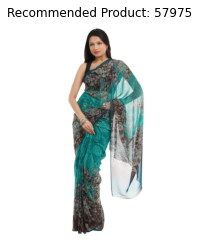

In [50]:
# Example usage
recommend_products_cosine(img_id=50889, img_emb=img_emb, num_recommendations=5)  # Replace with your actual img_id

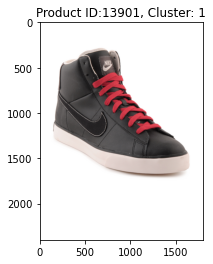

--------------------------------------------------------------------
Recommended Product ID: 13065, Similarity: 0.9376072036050269, Cluster: 1


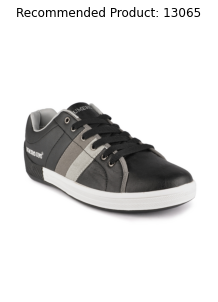

Recommended Product ID: 25444, Similarity: 0.9342885787647343, Cluster: 1


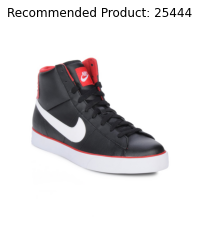

Recommended Product ID: 14557, Similarity: 0.9323649536836762, Cluster: 1


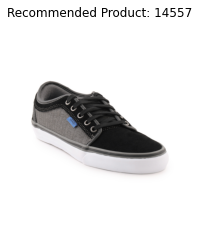

Recommended Product ID: 14572, Similarity: 0.9247128752632823, Cluster: 1


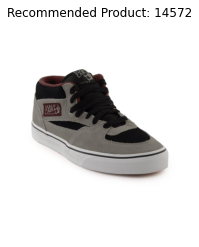

Recommended Product ID: 44781, Similarity: 0.9233017146948607, Cluster: 1


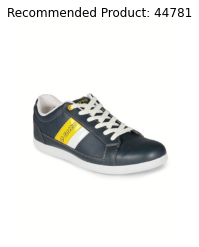

In [52]:
# Example usage
recommend_products_cosine(img_id=13901, img_emb=img_emb, num_recommendations=5)  # Replace with your actual img_id